In [1]:
import parametrization as param
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection import generating_moments
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d, interp2d
import seaborn as sns
from CentralStreamingModel.moments import moments2model, read
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
import taylor_tools as tt
sns.set_context('talk')

In [2]:
n_boxes = 5
boxsize = 1024
snapshot = 0
rm = read.Read_Mean(n_boxes, boxsize, snapshot)

In [3]:
parameters = [r'$m_r$',r'$c_r$',r'$c_t$',r'$\xi$']

In [4]:
ex = generating_moments.Expectations(rm.r, rm.v_r, rm.v_t,
                                     rm.jointpdf_rt)


In [5]:
s = np.arange(0.,50.,1)
mu = np.linspace(0.,1,60)


In [6]:
moments_projected = generating_moments.project(ex, rm.r_perp,
                                    rm.r_parallel)

In [7]:
gaussian = moments2model.Model(rm, moments_projected, model='gaussian')


In [8]:
gaussian.multipoles(s, mu) 

In [9]:
m_r = ex.moment(1,0)(rm.r)
c_r = ex.central_moment(2,0)(rm.r)
c_t = ex.central_moment(0,2)(rm.r)

## FIT THE LOWEST THREE MOMENTS

0.11102734537588807


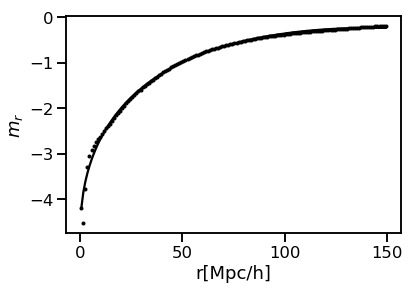

In [12]:
idx = 0

_, chi, popt_m_r = param.plot(tt.m_1, rm.r, m_r, 
        'black', 'Halos',parameters[idx], limit = 20)
#plt.text(40, -2, r'$\chi^2_\nu $ = %.2f'%chi, fontdict=dict(color='black'))
#plt.text(40,-2,r'$m_r(r) = A \sqrt{r} + B r + C$')

2.314160745363169


(6, 25)

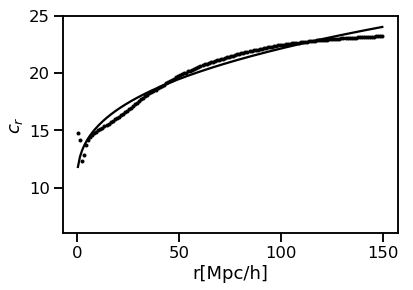

In [14]:
idx = 1

_, chi, popt_c_r = param.plot(tt.c_2, rm.r, c_r, 
        'black', 'Halos',parameters[idx], limit = 0)
#plt.text(40,5,r'$c_r(r) = A r^B + C$')

plt.ylim(6,25)

3.8706306673543964


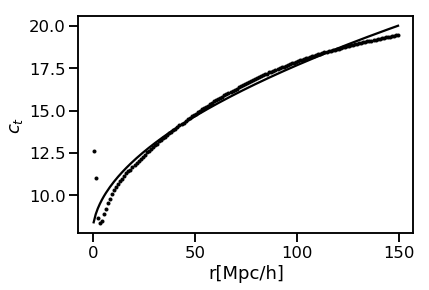

In [15]:
idx = 2

_, chi, popt_c_t = param.plot(tt.c_2, rm.r, c_t, 
        'black', 'Halos',parameters[idx], limit = 0)
#plt.text(10,15,r'$c_t(r) = A r^B + C$')


In [132]:
threshold = (rm.tpcf_dict['r'] > 10) & (rm.tpcf_dict['r'] < 50)

0.09257223095231334


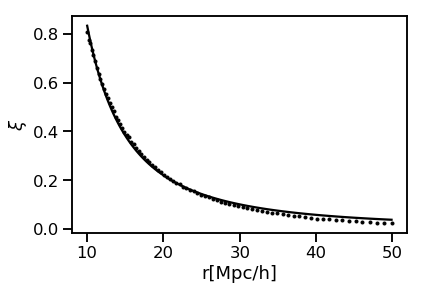

In [133]:
idx = 3

_, chi, popt_xi = param.plot(tt.xi, rm.tpcf_dict['r'][threshold], rm.tpcf_dict['tpcf'][threshold], 
        'black', 'Halos',parameters[idx], limit = 0)

#plt.text(10,15,r'$c_t(r) = A r^B + C$')

In [134]:
popt_xi

array([9.09125942, 1.92084023])

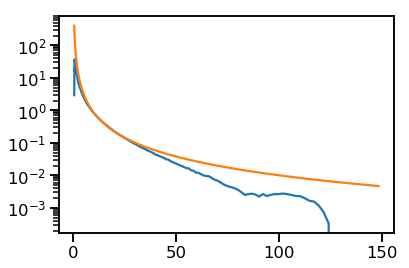

In [135]:
plt.semilogy(rm.tpcf_dict['r'], rm.tpcf_dict['tpcf'])
plt.semilogy(rm.tpcf_dict['r'], tt.xi(rm.tpcf_dict['r'], *popt_xi))


## GENERATE GAUSSIAN STREAMING MODEL WITH FITTED MOMENTS

In [21]:

moments_reduced = np.zeros((len(rm.r_perp), len(rm.r_parallel), 3))


for i, rper in enumerate(rm.r_perp):                                                                                                   
    for j, rpar in enumerate(rm.r_parallel):                                                                                           

        r_ = np.sqrt(rper**2 + rpar**2)                                                                                             
        mu_value = rpar/r_                                                                                                                


        moments_reduced[i,j, 0] = tt.m_1(r_, *popt_m_r) * mu_value                                                                                  

        moments_reduced[i,j, 1] = tt.c_2(r_, *popt_c_r) * mu_value**2 \
                            + tt.c_2(r_, *popt_c_t) * (1 - mu_value**2) 



In [22]:
gaussian_reduced = moments2model.Model(rm, moments_reduced, model = 'gaussian')

In [23]:
gaussian_reduced.multipoles(s, mu) 

In [24]:
measured = moments2model.Model(rm, moments_projected, 'measured')

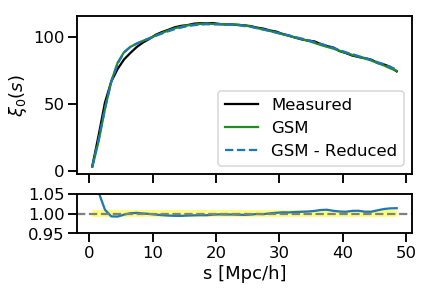

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.mono,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono,
        color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono,
        label = 'GSM - Reduced', linestyle='dashed')


ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.mono[1:]/gaussian.mono[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax1.legend()


Text(0.5,0,'s [Mpc/h]')

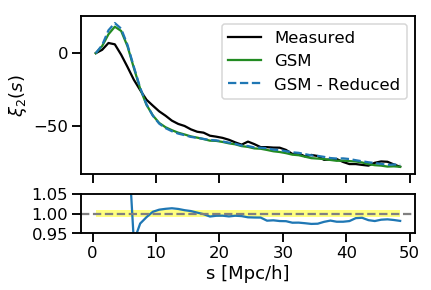

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.quad,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.quad,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad,
                label = 'GSM - Reduced', linestyle='dashed')

ax1.legend()
ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.quad[1:]/gaussian.quad[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

Text(0.5,0,'s [Mpc/h]')

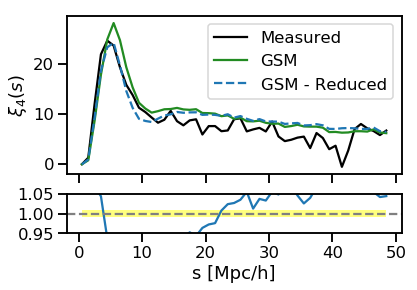

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.hexa,
        color = 'black', label = 'Measured')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.hexa,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa,
                label = 'GSM - Reduced', linestyle='dashed')

ax1.legend(bbox_to_anchor=(1,1))

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.hexa[1:]/gaussian.hexa[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

## TAYLOR EXPANSION

In [28]:
mono_1, quad_1, hexa_1 = tt.approximation(s, 1, 
                    popt_xi, popt_m_r, popt_c_r, popt_c_t, rm.tpcf_dict)
mono_2, quad_2, hexa_2 = tt.approximation(s, 2,
                    popt_xi, popt_m_r, popt_c_r, popt_c_t, rm.tpcf_dict)


In [143]:
mono_1_derivatives, quad_1_derivatives, hexa_1_derivatives = tt.approximation(s, 1,
                popt_xi, popt_m_r, popt_c_r, popt_c_t, 
                rm.tpcf_dict, derivatives = True)
mono_2_derivatives, quad_2_derivatives, hexa_2_derivatives = tt.approximation(s, 2,
                popt_xi, popt_m_r, popt_c_r, popt_c_t, 
                rm.tpcf_dict, derivatives = True)

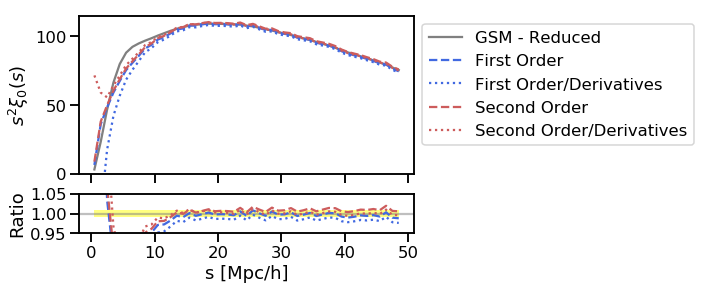

In [144]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1_derivatives, 
         label = 'First Order/Derivatives', linestyle='dotted', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2_derivatives,
         label = 'Second Order/Derivatives', linestyle='dotted', color = 'indianred')

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian_reduced.s_c[1:], 
         mono_1[1:]/gaussian_reduced.mono[1:],
         color = 'royalblue', linestyle='dashed')
ax2.plot(gaussian_reduced.s_c[1:],
         mono_2[1:]/gaussian_reduced.mono[1:], 
        color = 'indianred', linestyle='dashed')

ax2.plot(gaussian_reduced.s_c[1:], 
         mono_1_derivatives[1:]/gaussian_reduced.mono[1:],
         color = 'royalblue', linestyle='dotted')
ax2.plot(gaussian_reduced.s_c[1:],
         mono_2_derivatives[1:]/gaussian_reduced.mono[1:], 
        color = 'indianred', linestyle='dotted')

ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
ax1.set_ylim(0.,115)

ax1.legend(bbox_to_anchor=(1,1))

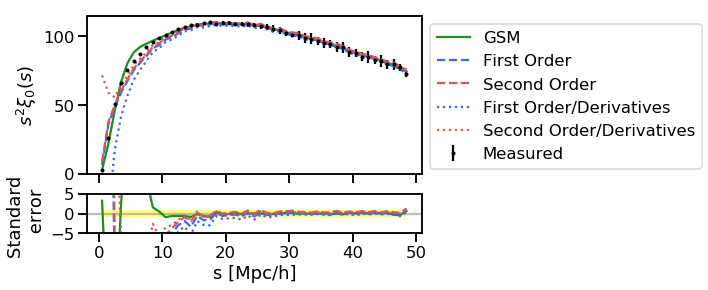

In [145]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.mono.mean,
            yerr =  rm.s_c * rm.s_c * rm.mono.std,
            color = 'black', linestyle='',
             label = 'Measured', marker='o',
             markersize=3)

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian.mono, 
         label = 'GSM', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1_derivatives, 
         label = 'First Order/Derivatives', linestyle='dotted', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2_derivatives,
         label = 'Second Order/Derivatives', linestyle='dotted', color = 'indianred')

ax2.axhline(y = 0., color='gray', linestyle='-', alpha = 0.5)
ax2.fill_between(gaussian_reduced.s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)


ax2.plot(gaussian.s_c, (gaussian.mono - rm.mono.mean)/rm.mono.std,
        color = 'forestgreen')
ax2.plot(gaussian.s_c, (mono_1 - rm.mono.mean)/rm.mono.std,
        color = 'royalblue', linestyle='dashed')
ax2.plot(gaussian.s_c, (mono_2 - rm.mono.mean)/rm.mono.std,
        color = 'indianred', linestyle='dashed')
ax2.plot(gaussian.s_c, (mono_1_derivatives - rm.mono.mean)/rm.mono.std,
        color = 'royalblue', linestyle='dotted')
ax2.plot(gaussian.s_c, (mono_2_derivatives - rm.mono.mean)/rm.mono.std,
        color = 'indianred', linestyle='dotted')



ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')



ax2.set_ylim(-5.,5)
ax2.set_ylabel("Standard \n error")
ax1.set_ylim(0.,115)


ax1.legend(bbox_to_anchor=(1,1))

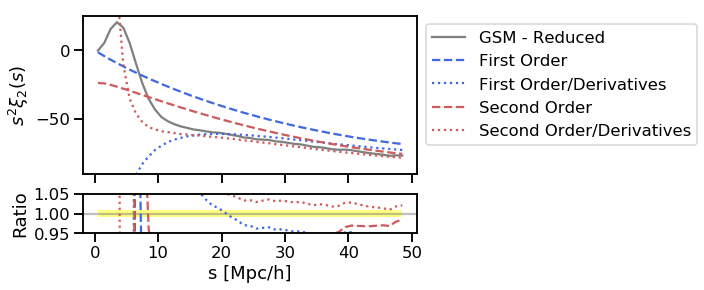

In [146]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1_derivatives, 
         label = 'First Order/Derivatives', linestyle='dotted', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2_derivatives,
         label = 'Second Order/Derivatives', linestyle='dotted', color = 'indianred')

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian_reduced.s_c[1:], 
         quad_1[1:]/gaussian_reduced.quad[1:],
         color = 'royalblue', linestyle='dashed')
ax2.plot(gaussian_reduced.s_c[1:],
         quad_2[1:]/gaussian_reduced.quad[1:], 
        color = 'indianred', linestyle='dashed')

ax2.plot(gaussian_reduced.s_c[1:], 
         quad_1_derivatives[1:]/gaussian_reduced.quad[1:],
         color = 'royalblue', linestyle='dotted')
ax2.plot(gaussian_reduced.s_c[1:],
         quad_2_derivatives[1:]/gaussian_reduced.quad[1:], 
        color = 'indianred', linestyle='dotted')

ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
ax1.set_ylim(-90,25)

ax1.legend(bbox_to_anchor=(1,1))

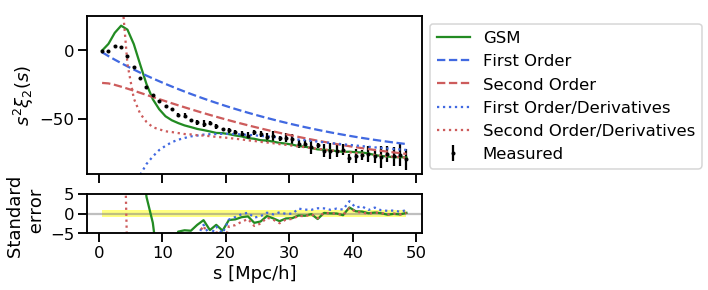

In [147]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.quad.mean,
            yerr =  rm.s_c * rm.s_c * rm.quad.std,
            color = 'black', linestyle='',
             label = 'Measured', marker='o',
             markersize=3)

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian.quad, 
         label = 'GSM', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1_derivatives, 
         label = 'First Order/Derivatives', linestyle='dotted', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2_derivatives,
         label = 'Second Order/Derivatives', linestyle='dotted', color = 'indianred')

ax2.axhline(y = 0., color='gray', linestyle='-', alpha = 0.5)
ax2.fill_between(gaussian_reduced.s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)


ax2.plot(gaussian.s_c, (gaussian.quad - rm.quad.mean)/rm.quad.std,
        color = 'forestgreen')
ax2.plot(gaussian.s_c, (quad_1 - rm.mono.mean)/rm.quad.std,
        color = 'royalblue', linestyle='dashed')
ax2.plot(gaussian.s_c, (quad_2 - rm.mono.mean)/rm.quad.std,
        color = 'indianred', linestyle='dashed')
ax2.plot(gaussian.s_c, (quad_1_derivatives - rm.quad.mean)/rm.quad.std,
        color = 'royalblue', linestyle='dotted')
ax2.plot(gaussian.s_c, (quad_2_derivatives - rm.quad.mean)/rm.quad.std,
        color = 'indianred', linestyle='dotted')



ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')



ax2.set_ylim(-5.,5)
ax2.set_ylabel("Standard \n error")
ax1.set_ylim(-90,25)


ax1.legend(bbox_to_anchor=(1,1))

In [3]:
import numpy as np
2 * np.pi / 0.2

31.41592653589793

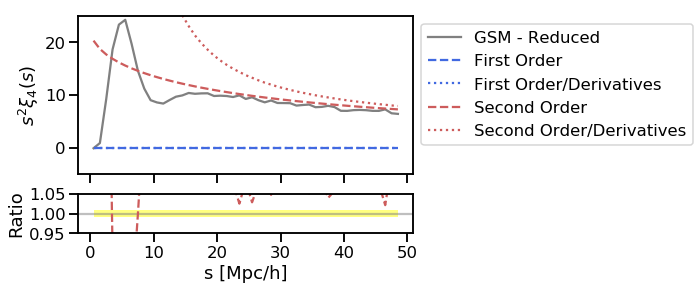

In [148]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1_derivatives, 
         label = 'First Order/Derivatives', linestyle='dotted', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2_derivatives,
         label = 'Second Order/Derivatives', linestyle='dotted', color = 'indianred')

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian_reduced.s_c[1:], 
         hexa_1[1:]/gaussian_reduced.hexa[1:],
         color = 'royalblue', linestyle='dashed')
ax2.plot(gaussian_reduced.s_c[1:],
         hexa_2[1:]/gaussian_reduced.hexa[1:], 
        color = 'indianred', linestyle='dashed')

ax2.plot(gaussian_reduced.s_c[1:], 
         hexa_1_derivatives[1:]/gaussian_reduced.hexa[1:],
         color = 'royalblue', linestyle='dotted')
ax2.plot(gaussian_reduced.s_c[1:],
         hexa_2_derivatives[1:]/gaussian_reduced.hexa[1:], 
        color = 'indianred', linestyle='dotted')

ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
ax1.set_ylim(-5,25)

ax1.legend(bbox_to_anchor=(1,1))

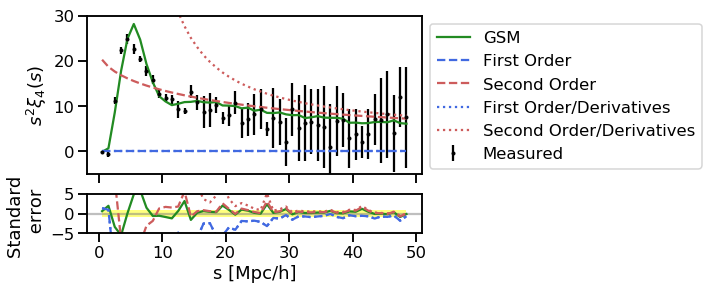

In [154]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.hexa.mean,
            yerr =  rm.s_c * rm.s_c * rm.hexa.std,
            color = 'black', linestyle='',
             label = 'Measured', marker='o',
             markersize=3)

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian.hexa, 
         label = 'GSM', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1_derivatives, 
         label = 'First Order/Derivatives', linestyle='dotted', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2_derivatives,
         label = 'Second Order/Derivatives', linestyle='dotted', color = 'indianred')

ax2.axhline(y = 0., color='gray', linestyle='-', alpha = 0.5)
ax2.fill_between(gaussian_reduced.s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)


ax2.plot(gaussian.s_c, (gaussian.hexa - rm.hexa.mean)/rm.hexa.std,
        color = 'forestgreen')
ax2.plot(gaussian.s_c, (hexa_1 - rm.hexa.mean)/rm.hexa.std,
        color = 'royalblue', linestyle='dashed')
ax2.plot(gaussian.s_c, (hexa_2 - rm.hexa.mean)/rm.hexa.std,
        color = 'indianred', linestyle='dashed')
ax2.plot(gaussian.s_c, (hexa_1_derivatives - rm.hexa.mean)/rm.hexa.std,
        color = 'royalblue', linestyle='dotted')
ax2.plot(gaussian.s_c, (hexa_2_derivatives - rm.hexa.mean)/rm.hexa.std,
        color = 'indianred', linestyle='dotted')



ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')



ax2.set_ylim(-5.,5)
ax2.set_ylabel("Standard \n error")
ax1.set_ylim(-5,30)


ax1.legend(bbox_to_anchor=(1,1))